In [67]:
# !pip install pytrends

from pandas_datareader import data as pdr
from datetime import date
# import yfinance as yf
# yf.pdr_override()
import pandas as pd
# import matplotlib.pyplot as plt
# import plotly.offline as pyo
from datetime import date

from pytrends.request import TrendReq
# import plotly.graph_objs as go

# pyo.init_notebook_mode()
import numpy as np
import yahoofinance as yf

## Import py trends

In [2]:
pytrend = TrendReq()

In [3]:
df = pytrend.trending_searches(pn='ukraine')#, start_data='06-04-2021', end_data='07-04-2021')
df.head(30)

,0
0,8 апреля праздник
1,День ангела Алла
2,Ольга Пашкова
3,Какой сегодня праздник
4,Челси
5,Ювентус – Наполі
6,Праздник сегодня
7,8 квітня свято
8,Березовий сік
9,Челси Порту


In [5]:
kw_list = [
          'bitcoin', 
          'bitcoin price',
          'bitcoin usd',
          'bitcoin kurs',
            'Bitcoin.com',
            'Bitcoin Gold',
           'BTC-USD',     
            'Bitcoin Cash',
       'binance',
    
    
            'cryptocurrency',
            'cryptocurrency bitcoin',
           'news cryptocurrency',
           'crypto',
           'buy bitcoin',
           'bitcoin stock',
           'best cryptocurrency',
           'cryptocurrency market',
           'buy cryptocurrency',
           'what is cryptocurrency',
           'cryptocurrency exchange',
          ]

def get_data_from_query(kw_list, timeframe='today 5-y', save=True):
    for word in kw_list:
        word_l = [word]
        get_result = pytrend.build_payload(word_l, cat=0, timeframe='today 5-y', geo='', gprop='')
        result = pytrend.interest_over_time()
        
        if save:
            result.to_csv(f'{word}_5YearAgo.csv')

In [234]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


class GatheringData():
    
    def __init__(self, start_day='2016-04-10', end_day=None): 
        self.df_pytrends = None
        self.df_yahoo = None
        self.start_day = start_day
        self.end_day = end_day
        self.pytrend = TrendReq()
        
        
    def get_from_google_trends(self, kw_list=[], 
                               timeframe='today 5-y', 
                               diretory=None, 
                               resample=None):
        
        assert len(kw_list) > 0, f'list of words must be not 0'
            
        resulting_df = []
        
        for word in kw_list:
            word_l = [word]
            get_result = self.pytrend.build_payload(word_l, cat=0, timeframe=timeframe, geo='', gprop='')
            result = self.pytrend.interest_over_time().drop('isPartial', axis=1)
            
            resulting_df.append(result)
            
        if diretory is not None:
            result.to_csv(f'{diretory}_{timeframe}.csv')
        
    
        if len(kw_list) > 1:    
            self.df_pytrends = pd.concat(resulting_df, axis=1)
        else:
            self.df_pytrends = resulting_df[0]
        
        if resample is not None:
            self.df_pytrends = self.df_pytrends.resample(resample).mean()
        
        return self.df_pytrends.copy()
    
    
    def get_from_yahoo(self, kw_list=[]):
        assert len(kw_list) > 0, f'list of words must be not 0'
        
        if self.end_day is None:
            self.end_day = date.today()
        
#         self.start_day = str(self.df_pytrends.index[0])[:6]
        data_queries = []
        
        kw_len = len(kw_list)
        
        for word in kw_list:
            data = yf.HistoricalPrices(word, start_date=self.start_day, end_date=self.end_day).to_dfs()
            data = data['Historical Prices']
            
            if kw_len >= 2:
                data = pd.DataFrame(data['Close'])
                data.columns = [f'Close_{word}']
                
            data_queries.append(data)
            
        if kw_len < 2:
            self.df_yahoo = pd.concat(data_queries, axis=1)
            
        else:
            kw_list = [x + '_close' for x in kw_list]
            self.df_yahoo = pd.concat(data_queries, names=kw_list, axis=1)
            
        return self.df_yahoo.copy()
    
    
    def get_resulting_from_sources(self):

        self.df_pytrends.index = self.df_yahoo.index[:self.df_pytrends.shape[0]]
            
        self.df_concated_yahoo_pytrends = pd.concat([self.df_yahoo, self.df_pytrends], axis=1).astype('float32')
        return self.df_concated_yahoo_pytrends.copy()
    
    
    def del_columns_result_data(self, columns=[]):
        assert len(columns) > 0, 'count of columns need to be not 0'
        
        self.df_concated_yahoo_pytrends = self.df_concated_yahoo_pytrends.drop(columns, axis=1)
        
        return self.df_concated_yahoo_pytrends.copy()
    
    
    def to_csv_df_concated_yahoo_pytrends(self, path=None):
        assert path is None, 'path does not be None'
        
        self.df_concated_yahoo_pytrends.to_csv(path)
        return self
    
    
    def to_csv_df_yahoo(self, path=None):
        assert path is None, 'path does not be None'
        
        self.df_yahoo.to_csv(path)
        return self
    
    
    def to_csv_df_pytrends(self, path=None):
        assert path is None, 'path does not be None'
        
        self.df_pytrends.to_csv(path)
        return self

In [235]:
kw_list = [
          'bitcoin', 
          'bitcoin price']

kw_list_yahoo = ['BTC-USD', 'ETH-USD']


get_data = GatheringData()
df_trends = get_data.get_from_google_trends(kw_list=kw_list, resample='D')
df_yahoo = get_data.get_from_yahoo(kw_list=kw_list_yahoo)
df = get_data.get_resulting_from_sources()

In [236]:
df

,Close_BTC-USD,Close_ETH-USD,bitcoin,bitcoin price
2016-04-10,421.563995,8.936340,2.0,1.0
2016-04-11,422.483002,8.643790,NaN,NaN
2016-04-12,425.190002,7.442310,NaN,NaN
2016-04-13,423.734009,8.044420,NaN,NaN
2016-04-14,424.282013,8.387240,NaN,NaN
...,...,...,...,...
2021-04-06,58192.359375,2118.378906,NaN,NaN
2021-04-07,56048.937500,1971.077271,NaN,NaN
2021-04-08,58323.953125,2088.573730,NaN,NaN
2021-04-09,58245.003906,2072.108887,NaN,NaN


In [219]:
del_col = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
get_data.del_columns_result_data(columns=del_col)

,Close,bitcoin,bitcoin price
2016-04-10,421.563995,2.0,1.0
2016-04-11,422.483002,NaN,NaN
2016-04-12,425.190002,NaN,NaN
2016-04-13,423.734009,NaN,NaN
2016-04-14,424.282013,NaN,NaN
...,...,...,...
2021-04-06,58192.359375,NaN,NaN
2021-04-07,56048.937500,NaN,NaN
2021-04-08,58323.953125,NaN,NaN
2021-04-09,58245.003906,NaN,NaN


In [212]:
# df_yahoo_new = df_yahoo.copy()
# df_trends_new = df_trends.copy()

get_data.resulting_df

,Open,High,Low,Close,Adj Close,Volume,bitcoin,bitcoin price
2016-04-10,419.592010,422.434998,419.256989,421.563995,421.563995,7.347860e+07,2.0,1.0
2016-04-11,421.872009,422.739014,420.532990,422.483002,422.483002,5.074750e+07,NaN,NaN
2016-04-12,422.842987,427.277008,422.842987,425.190002,425.190002,7.072880e+07,NaN,NaN
2016-04-13,425.631989,426.657990,422.915985,423.734009,423.734009,6.906040e+07,NaN,NaN
2016-04-14,423.934998,425.371002,423.013000,424.282013,424.282013,4.528100e+07,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-04-06,59171.933594,59479.578125,57646.808594,58192.359375,58192.359375,6.605803e+10,NaN,NaN
2021-04-07,58186.507812,58731.144531,55604.023438,56048.937500,56048.937500,7.564530e+10,NaN,NaN
2021-04-08,56099.914062,58338.738281,55879.085938,58323.953125,58323.953125,5.305385e+10,NaN,NaN
2021-04-09,58326.562500,58937.046875,57807.863281,58245.003906,58245.003906,4.665521e+10,NaN,NaN


In [216]:
get_data.yahoo_df = df_yahoo_new.copy()
get_data.pytrends_df = df_trends_new.copy()

In [204]:
get_data.pytrends_df

,bitcoin,bitcoin price
Date,,
2016-04-10,2.0,1.0
2016-04-11,NaN,NaN
2016-04-12,NaN,NaN
2016-04-13,NaN,NaN
2016-04-14,NaN,NaN
...,...,...
2021-03-31,NaN,NaN
2021-04-01,NaN,NaN
2021-04-02,NaN,NaN


In [205]:
get_data.yahoo_df.tail(10) 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-01,58926.562500,59586.070313,58505.277344,59095.808594,59095.808594,6.166916e+10
2021-04-02,59098.878906,60267.187500,58869.281250,59384.312500,59384.312500,5.872786e+10
2021-04-03,59397.410156,60110.269531,57603.890625,57603.890625,57603.890625,5.964134e+10
2021-04-04,57604.839844,58913.746094,57168.675781,58758.554688,58758.554688,5.074966e+10
2021-04-05,58760.875000,59891.296875,57694.824219,59057.878906,59057.878906,6.070627e+10
2021-04-06,59171.933594,59479.578125,57646.808594,58192.359375,58192.359375,6.605803e+10
2021-04-07,58186.507813,58731.144531,55604.023438,56048.937500,56048.937500,7.564530e+10
2021-04-08,56099.914063,58338.738281,55879.085938,58323.953125,58323.953125,5.305386e+10
2021-04-09,58326.562500,58937.046875,57807.863281,58245.003906,58245.003906,4.665521e+10


In [218]:
df = get_data.get_resulting_from_sources()
print(df.tail(10))

                    Open          High           Low         Close  \
2021-04-01  58926.562500  59586.070312  58505.277344  59095.808594   
2021-04-02  59098.878906  60267.187500  58869.281250  59384.312500   
2021-04-03  59397.410156  60110.269531  57603.890625  57603.890625   
2021-04-04  57604.839844  58913.746094  57168.675781  58758.554688   
2021-04-05  58760.875000  59891.296875  57694.824219  59057.878906   
2021-04-06  59171.933594  59479.578125  57646.808594  58192.359375   
2021-04-07  58186.507812  58731.144531  55604.023438  56048.937500   
2021-04-08  56099.914062  58338.738281  55879.085938  58323.953125   
2021-04-09  58326.562500  58937.046875  57807.863281  58245.003906   
2021-04-10  60830.441406  61235.007812  58067.121094  60407.421875   

               Adj Close        Volume  bitcoin  bitcoin price  
2021-04-01  59095.808594  6.166916e+10      NaN            NaN  
2021-04-02  59384.312500  5.872786e+10      NaN            NaN  
2021-04-03  57603.890625  5.964134

In [207]:
df.tail(20)

,Open,High,Low,Close,Adj Close,Volume,bitcoin,bitcoin price
2021-03-22,57517.890625,58471.480469,54288.156250,54529.144531,54529.144531,5.652145e+10,NaN,NaN
2021-03-23,54511.660156,55985.441406,53470.695312,54738.945312,54738.945312,5.643502e+10,NaN,NaN
2021-03-24,54710.488281,57262.382812,52514.332031,52774.265625,52774.265625,7.056722e+10,NaN,NaN
2021-03-25,52726.746094,53392.386719,50856.570312,51704.160156,51704.160156,6.799981e+10,NaN,NaN
2021-03-26,51683.011719,55137.312500,51579.855469,55137.312500,55137.312500,5.665220e+10,NaN,NaN
2021-03-27,55137.566406,56568.214844,54242.910156,55973.511719,55973.511719,4.726654e+10,NaN,NaN
2021-03-28,55974.941406,56610.312500,55071.113281,55950.746094,55950.746094,4.768658e+10,36.0,36.0
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57750.199219,5.762559e+10,NaN,NaN
2021-03-30,57750.132812,59447.222656,57251.550781,58917.691406,58917.691406,5.441411e+10,NaN,NaN
2021-03-31,58930.277344,59930.027344,57726.417969,58918.832031,58918.832031,6.552082e+10,NaN,NaN


In [55]:
df_trends

,bitcoin,bitcoin price
date,,
2016-04-10,2.0,1.0
2016-04-11,NaN,NaN
2016-04-12,NaN,NaN
2016-04-13,NaN,NaN
2016-04-14,NaN,NaN
...,...,...
2021-03-31,NaN,NaN
2021-04-01,NaN,NaN
2021-04-02,NaN,NaN


In [77]:
df_trends.index = df_yahoo.index[:df_trends.shape[0]]

In [86]:
df_trends
pd.concat([df_trends.append(cop_data), df_yahoo], axis=1)

,bitcoin,bitcoin price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,
2016-04-10,2.0,1.0,419.592010,422.434998,419.256989,421.563995,421.563995,7.347860e+07
2016-04-11,NaN,NaN,421.872009,422.739014,420.532990,422.483002,422.483002,5.074750e+07
2016-04-12,NaN,NaN,422.842987,427.277008,422.842987,425.190002,425.190002,7.072880e+07
2016-04-13,NaN,NaN,425.631989,426.657990,422.915985,423.734009,423.734009,6.906040e+07
2016-04-14,NaN,NaN,423.934998,425.371002,423.013000,424.282013,424.282013,4.528100e+07
...,...,...,...,...,...,...,...,...
2021-04-06,NaN,NaN,59171.933594,59479.578125,57646.808594,58192.359375,58192.359375,6.605803e+10
2021-04-07,NaN,NaN,58186.507813,58731.144531,55604.023438,56048.937500,56048.937500,7.564530e+10
2021-04-08,NaN,NaN,56099.914063,58338.738281,55879.085938,58323.953125,58323.953125,5.305386e+10


In [81]:
df_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1827 entries, 2016-04-10 to 2021-04-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1817 non-null   float64
 1   High       1817 non-null   float64
 2   Low        1817 non-null   float64
 3   Close      1817 non-null   float64
 4   Adj Close  1817 non-null   float64
 5   Volume     1817 non-null   float64
dtypes: float64(6)
memory usage: 179.9+ KB


In [73]:
cop_data = df_yahoo.iloc[df_trends.shape[0]:, :df_trends.shape[1]]
cop_data.columns = df_trends.columns
cop_data.iloc[:,:] = np.nan
cop_data

,bitcoin,bitcoin price
Date,,
2021-04-05,NaN,NaN
2021-04-06,NaN,NaN
2021-04-07,NaN,NaN
2021-04-08,NaN,NaN
2021-04-09,NaN,NaN
2021-04-10,NaN,NaN


In [57]:
row_appended = [None] * df_trends.shape[1]
pd.appdf_trends.append(row_appended, axis=0)

TypeError: append() got an unexpected keyword argument 'axis'

In [56]:
df_yahoo

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-10,419.592010,422.434998,419.256989,421.563995,421.563995,7.347860e+07
2016-04-11,421.872009,422.739014,420.532990,422.483002,422.483002,5.074750e+07
2016-04-12,422.842987,427.277008,422.842987,425.190002,425.190002,7.072880e+07
2016-04-13,425.631989,426.657990,422.915985,423.734009,423.734009,6.906040e+07
2016-04-14,423.934998,425.371002,423.013000,424.282013,424.282013,4.528100e+07
...,...,...,...,...,...,...
2021-04-06,59171.933594,59479.578125,57646.808594,58192.359375,58192.359375,6.605803e+10
2021-04-07,58186.507813,58731.144531,55604.023438,56048.937500,56048.937500,7.564530e+10
2021-04-08,56099.914063,58338.738281,55879.085938,58323.953125,58323.953125,5.305386e+10


In [45]:
df_yahoo.shape, df_trends.shape

((1827, 6), (1821, 2))

In [79]:
pd.concat([df_yahoo, df_trends], axis=1)

,Open,High,Low,Close,Adj Close,Volume,bitcoin,bitcoin price
2016-04-10,419.592010,422.434998,419.256989,421.563995,421.563995,73478600.0,2.0,1.0
2016-04-11,421.872009,422.739014,420.532990,422.483002,422.483002,50747500.0,NaN,NaN
2016-04-12,422.842987,427.277008,422.842987,425.190002,425.190002,70728800.0,NaN,NaN
2016-04-13,425.631989,426.657990,422.915985,423.734009,423.734009,69060400.0,NaN,NaN
2016-04-14,423.934998,425.371002,423.013000,424.282013,424.282013,45281000.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
pytrends_df = None
if len(kw_list) > 1:    
    pytrends_df = pd.concat(df_trends, axis=1)
    
else:
    pytrends_df = resulting_df[0]

# if resample is not None:
#     pytrends_df = self.pytrends_df.resampfhele(resample).mean()
pytrends_df
# return self.pytrends_df

,bitcoin,bitcoin price
date,,
2016-04-10,2,1
2016-04-17,2,1
2016-04-24,3,1
2016-05-01,4,1
2016-05-08,3,1
...,...,...
2021-03-07,41,41
2021-03-14,41,41
2021-03-21,36,35


In [29]:
df_yahoo

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-10,419.592010,422.434998,419.256989,421.563995,421.563995,7.347860e+07
2016-04-11,421.872009,422.739014,420.532990,422.483002,422.483002,5.074750e+07
2016-04-12,422.842987,427.277008,422.842987,425.190002,425.190002,7.072880e+07
2016-04-13,425.631989,426.657990,422.915985,423.734009,423.734009,6.906040e+07
2016-04-14,423.934998,425.371002,423.013000,424.282013,424.282013,4.528100e+07
...,...,...,...,...,...,...
2021-04-06,59171.933594,59479.578125,57646.808594,58192.359375,58192.359375,6.605803e+10
2021-04-07,58186.507813,58731.144531,55604.023438,56048.937500,56048.937500,7.564530e+10
2021-04-08,56099.914063,58338.738281,55879.085938,58323.953125,58323.953125,5.305386e+10


In [28]:
pd.concat(df_trends, axis=1)

,bitcoin,bitcoin price
date,,
2016-04-10,2,1
2016-04-17,2,1
2016-04-24,3,1
2016-05-01,4,1
2016-05-08,3,1
...,...,...
2021-03-07,41,41
2021-03-14,41,41
2021-03-21,36,35


            cryptocurrency exchange isPartial
date                                         
2016-04-10                        1     False
2016-04-17                        0     False
2016-04-24                        0     False
2016-05-01                        0     False
2016-05-08                        1     False
...                             ...       ...
2021-03-07                       10     False
2021-03-14                        9     False
2021-03-21                       10     False
2021-03-28                       10     False
2021-04-04                       12      True

[261 rows x 2 columns]


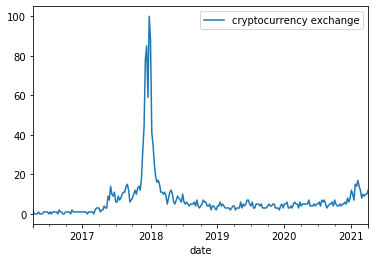

In [4]:
kw_list = [
          'bitcoin', 
          'bitcoin price',
          'bitcoin usd',
          'bitcoin kurs',
            'Bitcoin.com',
            'Bitcoin Gold',
           'BTC-USD',     
            'Bitcoin Cash',
       'binance',
    
    
            'cryptocurrency',
            'cryptocurrency bitcoin',
           'news cryptocurrency',
           'crypto',
           'buy bitcoin',
           'bitcoin stock',
           'best cryptocurrency',
           'cryptocurrency market',
           'buy cryptocurrency',
           'what is cryptocurrency',
           'cryptocurrency exchange',
          ]
for word in kw_list:
    word_l = [word]
    get_result = pytrend.build_payload(word_l, cat=0, timeframe='today 5-y', geo='', gprop='')
    result = pytrend.interest_over_time()
    result.to_csv(f'{word}_5YearAgo.csv')

print(result)
result.plot()